In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic

#plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

## buffer

the simplest circuit to begin with, is a voltage buffer. the buffer confifuration looks similar to the opamp buffer. but there are some differences. the first important difference is that the feedback will also do the biasing of the signal. when an ac signal is fed into the buffer the output will be a dc signal, as long as the chip is able to provide the needed feedback. the gain can be calculated similar to the opamp configuration. but there will be less gain as we would excpect from the calculation. 

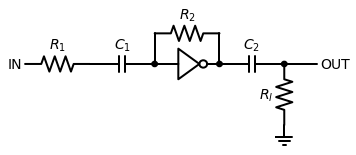

In [2]:
d = schemdraw.Drawing(unit=2.0, inches_per_unit=0.5, lw=0.9)
R = d.add(elm.Resistor( lftlabel="IN", label='$R_1$'))
d.add(elm.Capacitor(label='$C_1$'))
N = d.add(logic.Not)
C = d.add(elm.Capacitor(label='$C_2$'))
d.add(elm.Resistor("down",label='$R_l$'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Resistor('right', label='$R_2$'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=C.end))
d.add(elm.Line('right', l=d.unit/2, rgtlabel='OUT'))

d.draw()

this is the first setup with the 4069 as voltage follower. C1 and C3 are the dc blocking capacitors. when we choose R1 and R2 as 100kOhm we would excpect a gain of one.

In [3]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2.5V SIN(0 2.5V 1k)')

circuit.X('1', '4069UB', 'gate_in', 'gate_out', '+5V', circuit.gnd)
circuit.R(2, 'gate_out', 'gate_in', 100@u_kΩ)
circuit.C(1, 'gate_in', 'R1out', 47@u_nF)
circuit.R(1, 'R1out', 'IN', 100@u_kΩ)
circuit.C(2, 'gate_out', 'OUT', 1@u_uF)
R = circuit.R('load', 'OUT', circuit.gnd, 100@u_kΩ)


In [4]:
buffer_data = []
for r in (100@u_kΩ, 125@u_kΩ, 150@u_kΩ, 175@u_kΩ, 200@u_kΩ):
    circuit.R2.resistance = r

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=100@u_Hz, number_of_points=10,  variation='dec')
    analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=1@u_ms)
    buffer_data.append(np.array(analysis['OUT']))


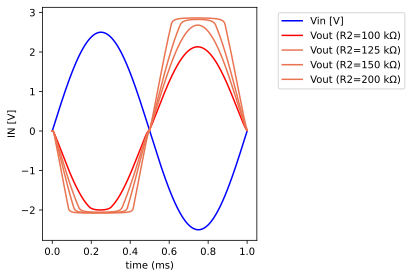

In [5]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Blue')
buffer_axis, = ax1_buffer.plot(u_ms(analysis['OUT'].abscissa), buffer_data[0], color='Red')
ax1_buffer.plot(u_ms(analysis['OUT'].abscissa), buffer_data[1], color='#E97451')
ax1_buffer.plot(u_ms(analysis['OUT'].abscissa), buffer_data[2], color='#E97451')
#ax1.plot(u_ms(analysis['OUT'].abscissa), buffer_data[3], color='#E97451')
ax1_buffer.plot(u_ms(analysis['OUT'].abscissa), buffer_data[4], color='#E97451')
ax1_buffer.legend(('Vin [V]', 'Vout (R2=100 kΩ)', 'Vout (R2=125 kΩ)', 'Vout (R2=150 kΩ)', 'Vout (R2=200 kΩ)'), loc=(1.1,0.65))

plt.tight_layout()
plt.show()

the blue slope is the input signal (5Vp2p) and the red the output with 100kOhm resistors. the output is a little less as excpected. there is also a glitch around 0V. later we will see if the real chip will also show this behaviour or if this is only in the simulation. for the other signals the resistor R2 is replaced with 125kΩ, 150kΩ, 175kΩ and 200kΩ. with xx the gain is roughly one, but with higher gain we see that there is not enough headroom for the chip to do proper amplification, the signal is soft clipped. this soft clipping is the special characteristic of this chip, which makes it so pupular for guitar stomp boxes.

## distortion

now we want to analyze the distortion. we add another stage with a very high gain.

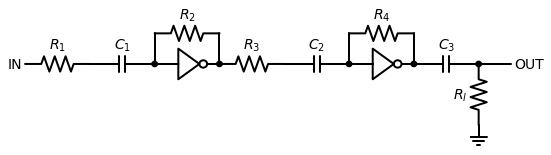

In [6]:
d = schemdraw.Drawing(unit=2.0, inches_per_unit=0.5, lw=0.9)
R1 = d.add(elm.Resistor( lftlabel='IN', label='$R_1$'))
d.add(elm.Capacitor(label='$C_1$'))
N1 = d.add(logic.Not)

R2 = d.add(elm.Resistor( label='$R_3$'))
d.add(elm.Capacitor(label='$C_2$'))
N2 = d.add(logic.Not)


C = d.add(elm.Capacitor(label='$C_3$'))
d.add(elm.Resistor("down",label='$R_l$'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N1.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Resistor('right', label='$R_2$'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=N2.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Resistor('right', label='$R_4$'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=C.end))
d.add(elm.Line('right', l=d.unit/2, rgtlabel='OUT'))

d.draw()

in the simulation R2 is unchanched. For R4 the simulation is done with 100kΩ, 150kΩ, 500Ω, 1MΩ and 10MΩ.

In [7]:
circuit = Circuit('cmos buffer with distortion')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2.5V SIN(0 2.5V 1k)')

circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+5V', circuit.gnd)
circuit.X('2', '4069UB', 'gate_in_2', 'gate_out_2', '+5V', circuit.gnd)
circuit.R(2, 'gate_out_1', 'gate_in_1', 100@u_kΩ)
circuit.C(9, 'gate_out_1', 'gate_in_1', 100@u_pF)
circuit.C(1, 'gate_in_1', 'R1out', 47@u_nF)
circuit.R(1, 'R1out', 'IN', 100@u_kΩ)
circuit.R(3, 'gate_out_1', 'r3_out', 100@u_kΩ)
circuit.C(2, 'r3_out', 'gate_in_2', 100@u_nF)
circuit.R(4, 'gate_in_2', 'gate_out_2', 300@u_kΩ)
circuit.C(5, 'gate_in_2', 'gate_out_2', 100@u_pF)

circuit.C(3, 'gate_out_2', 'OUT', 1@u_uF)
R = circuit.R('load', 'OUT', circuit.gnd, 100@u_kΩ)

In [8]:
buffer_data = []
for r in (100@u_kΩ, 150@u_kΩ, 500@u_kΩ, 1@u_MΩ, 10@u_MΩ):
    circuit.R4.resistance = r

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=100@u_Hz, number_of_points=10,  variation='dec')
    analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=1@u_ms)
    buffer_data.append(np.array(analysis['OUT']))

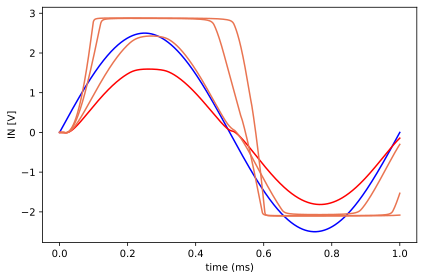

In [9]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
ax1.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Blue')
ax1.plot(u_ms(analysis['OUT'].abscissa), buffer_data[0], color='Red')
ax1.plot(u_ms(analysis['OUT'].abscissa), buffer_data[1], color='#E97451')
ax1.plot(u_ms(analysis['OUT'].abscissa), buffer_data[2], color='#E97451')
#ax1.plot(u_ms(analysis['OUT'].abscissa), buffer_data[3], color='#E97451')
ax1.plot(u_ms(analysis['OUT'].abscissa), buffer_data[4], color='#E97451')

plt.tight_layout()
plt.show()

the simulation looks similar to the first one. we can see that the signal is transforming into a square wave, but always with the soft clipping.

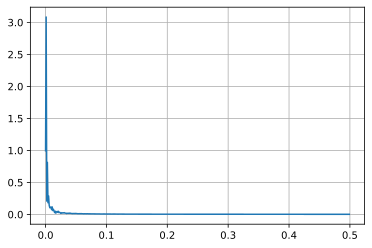

In [11]:
from scipy.fft import fft, fftfreq
# Number of sample points
N = len(buffer_data[4])
# sample spacing
T = 1.0 #/ 10.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = buffer_data[4]
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

## *references*

- [CD4069][1] Datasheet
